# Estimativa da direção de magnetização de uma esfera

## Importando as bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import prism_mag

In [3]:
import eqlayer

## Gerando os parâmetros das coordenadas

In [4]:
Nx = 100
Ny = 50
area = [-1000.,1000.,-1000.,1000.]
shape = (Nx,Ny)

In [5]:
x = np.linspace(area[0],area[1],num=Nx)
y = np.linspace(area[2],area[3],num=Ny) 
yc,xc = np.meshgrid(y,x)

In [6]:
voo = -200.
zc = voo*np.ones_like(xc)

In [7]:
coordinates = np.array([yc.ravel(),xc.ravel(),zc.ravel()])

## Gerando os parâmetros do prisma

In [8]:
intensidades = np.array([50.])

In [9]:
direcoes = np.array([[-40.,-50.]])

In [10]:
modelo = np.array([[-50.,50.,-50.,50.,50.,150.]])

## Cálculo das componentes do campo de gravidade e do potencial

In [11]:
bz = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_z")

In [12]:
bx = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_x")

In [13]:
by = prism_mag.magnetics(coordinates,modelo,intensidades,direcoes,field="b_y")

### Anomalia de campo total aproximada

In [14]:
I0,D0 = -20.,-20.
j0x = np.cos(np.deg2rad(I0))*np.cos(np.deg2rad(D0))
j0y = np.cos(np.deg2rad(I0))*np.sin(np.deg2rad(D0))
j0z = np.sin(np.deg2rad(I0))
tfa = j0x*bx + j0y*by + j0z*bz

### Gerando um conjunto de dados observados com ruído Gaussiano

In [15]:
np.random.seed(seed=40)
std_noise = 0.03*np.max(np.abs(tfa))

r = np.random.normal(0.0, std_noise, tfa.size)

print ('%.3f nT' % std_noise)

4.492 nT


In [16]:
tfa_obs = tfa + r

## Visualização dos dados calculados 

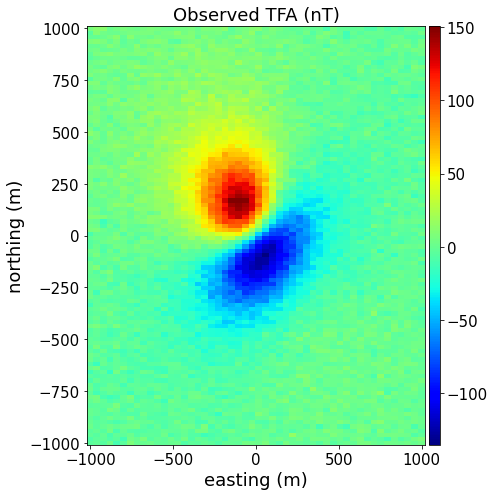

In [17]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_obs.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

file_name = 'images/observed_TFA'
plt.savefig(file_name+'.png',dpi=300)

plt.show()

## Resolvendo o problema inverso para realizar a RTP

In [18]:
main_field = np.array([-20.,-20.])
magnetization = np.array([-40.,-50.])

In [19]:
depth = 200.
zs = depth*np.ones_like(xc)
ys = yc
xs = xc

In [20]:
sources = np.array([ys.ravel(),xs.ravel(),zs.ravel()])

In [21]:
I = np.identity(xs.size)

In [22]:
G = eqlayer.sensitivity(coordinates,sources,main_field,magnetization)

In [23]:
mu = 1e-9

In [24]:
p = np.linalg.solve(np.dot(G.T,G) + mu*I,np.dot(G.T,tfa_obs))

In [25]:
tfa_pred = eqlayer.tfa(coordinates,sources,main_field,p,magnetization)

In [26]:
residuals = tfa_obs - tfa_pred
mean = np.mean(residuals)
std_deviation = np.std(residuals)

### Comparando dado observado com dado predito

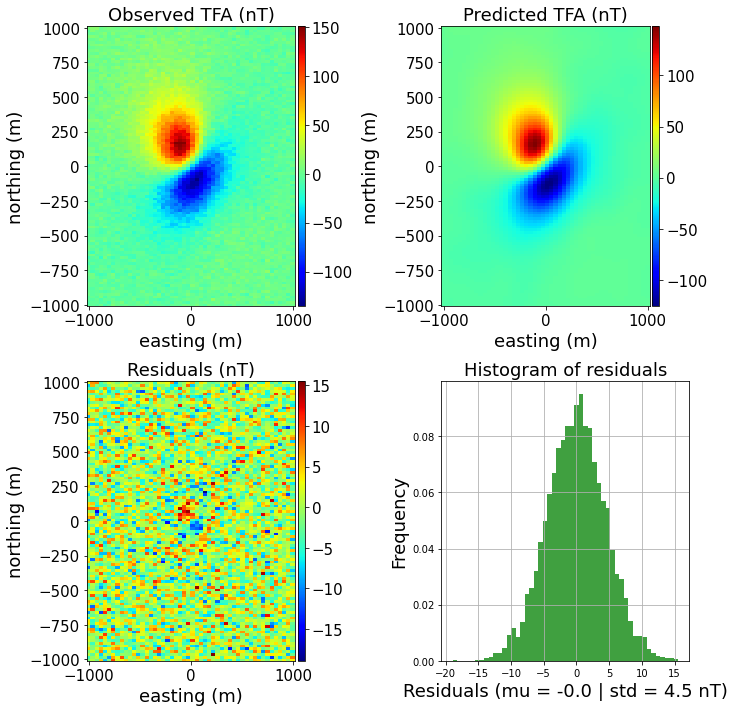

In [27]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(10,10), tight_layout=True)

plt.subplot(2,2,1)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Observed TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_obs.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,2)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Predicted TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_pred.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,3)
plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Residuals (nT)', fontsize=title_font)
plt.pcolor(yc,xc,residuals.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

plt.subplot(2,2,4)
n, bins, patches = plt.hist(residuals, 50, density=True, facecolor='g', alpha=0.75)
plt.xlabel('Residuals (mu = %.1f | std = %.1f nT)' % (mean,std_deviation),fontsize = title_font)
plt.ylabel('Frequency',fontsize = title_font)
plt.title('Histogram of residuals',fontsize = title_font)
plt.grid(True)


#file_name = 'images/forward_modeling_mag_prism_mag_tot_HS'
#plt.savefig(file_name+'.png',dpi=300)

plt.show()

## Realizando a Redução ao polo 

In [28]:
induction_field = np.array([90.,0.])
induced_magnetization = np.array([90.,0.])

In [29]:
tfa_rtp = eqlayer.tfa(coordinates,sources,induction_field,p,induced_magnetization)

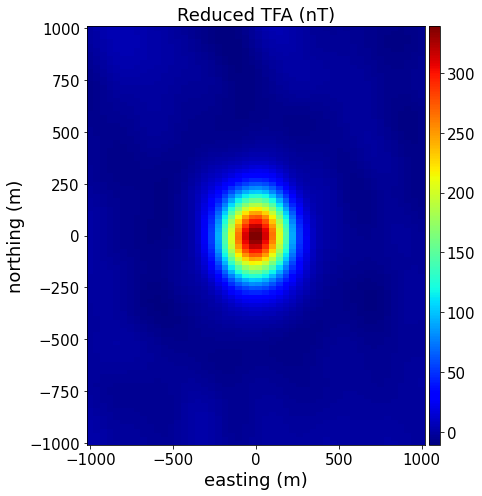

In [30]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

plt.xlabel('easting (m)', fontsize = title_font)
plt.ylabel('northing (m)', fontsize = title_font)
plt.title('Reduced TFA (nT)', fontsize=title_font)
plt.pcolor(yc,xc,tfa_rtp.reshape(shape),shading='auto',cmap='jet')
plt.tick_params(axis='both', which='major', labelsize=bottom_font)
cb = plt.colorbar(pad=0.01, aspect=40, shrink=1.0)
cb.ax.tick_params(labelsize=bottom_font)

#file_name = 'images/observed_TFA'
#plt.savefig(file_name+'.png',dpi=300)

plt.show()